In [114]:
# Optimized cache-controller
states = [
    "Proc_I", "Proc_IS_D", "Proc_IM_D", "Proc_IM_A", "Proc_S",
    "Proc_SM_D", "Proc_SM_A", "Proc_M", "Proc_MS_A", "Proc_MI_A",
    "Proc_SI_A", "Proc_II_A"
]

transitions = [
    ("Proc_M", "Evict", "Send(PutM, Home)", "Proc_MI_A"),
    ("Proc_S", "Evict", "Send(PutS, Home)", "Proc_SI_A"),
    ("Proc_M", "Self-downgrade", "Send(PutMS, Home)", "Proc_MS_A"),
    ("Proc_S", "Store", "Send(GetM, Home)", "Proc_SM_D"),
    ("Proc_I", "Store", "Send(GetM, Home)", "Proc_IM_D"),
    ("Proc_I", "Load", "Send(GetS, Home)", "Proc_IS_D"),
    ("Proc_I", "Inv", "Send(Inv, pnxt)", "Proc_I"),
    ("Proc_IS_D", "Inv", "Stall", "Proc_IS_D"),
    ("Proc_IS_D", "Data", "Update pval", "Proc_S"),
    ("Proc_IS_D", "DNAck", "CMI reject", "Proc_I"),
    ("Proc_IM_D", "Inv", "Send(Inv, pnxt)", "Proc_IM_D"),
    ("Proc_IM_D", "FwdGetS/FwdGetM", "Stall", "Proc_IM_D"),
    ("Proc_IM_D", "Data from HomeDir, ack_cnt=0", "Send(Inv, pnxt)", "Proc_M"),
    ("Proc_IM_D", "Data from HomeDir, ack_cnt>0", "Start CMI chain, Send(Inv, pnxt)", "Proc_IM_A"),
    ("Proc_IM_D", "Data from Previous Owner", "Update pval", "Proc_M"),
    ("Proc_IM_A", "FwdGetS/FwdGetM", "Stall", "Proc_IM_A"),
    ("Proc_IM_A", "Inv", "Send(InvAck, HomeDir)", "Proc_M"),
    ("Proc_S", "Inv", "Send(Inv, pnxt)", "Proc_I"),
    ("Proc_SM_D", "FwdGetS/FwdGetM", "Stall", "Proc_SM_D"),
    ("Proc_SM_D", "Inv", "Send(Inv, pnxt)", "Proc_IM_D"),
    ("Proc_SM_D", "Data, ack_cnt=0", "Send(Inv, pnxt)", "Proc_M"),
    ("Proc_SM_D", "Data, ack_cnt>0", "Start CMI chain, Send(Inv, pnxt)", "Proc_SM_A"),
    ("Proc_SM_A", "FwdGetS/FwdGetM", "Stall", "Proc_SM_A"),
    ("Proc_SM_A", "Inv", "Send(InvAck, HomeDir)", "Proc_M"),
    ("Proc_M", "Inv", "Send(Inv, pnxt)", "Proc_M"),
    ("Proc_M", "FwdGetS", "Send(FwdAck, HomeDir); Send(Data, fwd)", "Proc_S"),
    ("Proc_M", "FwdGetM", "Send(Data, fwd); Send(FwdAck, HomeDir)", "Proc_I"),
    ("Proc_MS_A", "Inv", "Send(Inv, pnxt)", "Proc_MI_A"),
    ("Proc_MS_A", "FwdGetS", "Send(Data, fwd); Send(FwdAck, home)", "Proc_MS_A"),
    ("Proc_MS_A", "FwdGetM", "Send(Data, fwd); Send(FwdAck, home)", "Proc_MI_A"),
    ("Proc_MS_A", "PutAck", "Self-downgrade complete", "Proc_S"),
    ("Proc_MI_A", "Inv", "Send(Inv, pnxt)", "Proc_MI_A"),
    ("Proc_MI_A", "FwdGetS", "Send(FwdAck, HomeDir); Send(Data, fwd)", "Proc_SI_A"),
    ("Proc_MI_A", "FwdGetM", "Send(Data, fwd); Send(FwdAck, HomeDir)", "Proc_II_A"),
    ("Proc_MI_A", "PutAck; Ack_Cnt = 0", "PutAck is for PutM", "Proc_I"),
    ("Proc_MI_A", "PutAck; Ack_Cnt = 1", "PutAck is for PutMS", "Proc_SI_A"),
    ("Proc_SI_A", "Inv", "Send(Inv, pnxt)", "Proc_II_A"),
    ("Proc_SI_A", "PutAck", "", "Proc_I"),
    ("Proc_II_A", "Inv", "Send(Inv, pnxt)", "Proc_II_A"),
    ("Proc_II_A", "PutAck", "", "Proc_I"),
]

In [50]:
# Optimized directory-controller
states_dir = [
    "Dir_M", "Dir_S", "Dir_I", "Dir_MS_D", "Dir_MM_A", "Dir_SM_A"
]

transitions_dir = [
    ("Dir_I", "GetS", "Send(Data, req), AddSharer(req)", "Dir_S"),
    ("Dir_I", "GetM", "Send(Data, req, sharerCount), SetOwner(req)", "Dir_M"),
    ("Dir_I", "PutS/PutM/PutMS", "Send(PutAck, req, (1 if PutMS, else 0))", "Dir_I"),
    
    ("Dir_S", "GetS", "Send(Data, req), AddSharer(req)", "Dir_S"),
    ("Dir_S", "GetM; req only sharer", "Send(Data, req), SetOwner(req), clear Sharers", "Dir_M"),
    ("Dir_S", "GetM; otherwise", "Send(Data, req), SetOwner(req)", "Dir_SM_A"),
    ("Dir_S", "PutS/PutM/PutMS; req only sharer", "RemoveFromSharers(req), Send(PutAck, req)", "Dir_I"),
    ("Dir_S", "PutS/PutM/PutMS; otherwise", "RemoveFromSharers(req), Send(PutAck, req)", "Dir_S"),
    
    ("Dir_M", "GetS", "Send(FwdGetS, Owner), AddSharer(req), AddSharer(Owner)", "Dir_MS_D"),
    ("Dir_M", "GetM", "Send(FwdGetM, Owner), SetOwner(req)", "Dir_MM_A"),
    ("Dir_M", "PutS", "Send(PutAck, req)", "Dir_M"),
    ("Dir_M", "PutM owner", "StoreToMemory, ClearOwner, Send(PutAck, req)", "Dir_I"),
    ("Dir_M", "PutMS owner", "StoreToMemory, ClearOwner, Send(PutAck, req), AddSharer(req)", "Dir_S"),
    ("Dir_M", "PutM/PutMS owner", "Send(PutAck, req)", "Dir_S"),
    
    ("Dir_MS_D", "GetS; GetM; PutS; PutM; PutMS; Data", "Stall", "Dir_MS_D"),
    ("Dir_MS_D", "FwdAck", "Update home value", "Dir_S"),
    
    ("Dir_MM_A", "GetS; GetM; PutS; PutM; PutMS; Data", "Stall", "Dir_MM_A"),
    ("Dir_MM_A", "FwdAck", "Update home value", "Dir_M"),
    
    ("Dir_SM_A", "GetS", "Send(DNAck, req)", "Dir_SM_A"),
    ("Dir_SM_A", "GetM; PutS; PutM; PutMS; Data", "Stall", "Dir_SM_A"),
    ("Dir_SM_A", "InvAck; from owner", "Clear sharers", "Dir_M")
]


In [117]:
# Base MSI cache-controller
states = [
    "Proc_I", "Proc_IS_D", "Proc_IM_AD", "Proc_IM_A", "Proc_S",
    "Proc_SM_AD", "Proc_SM_A", "Proc_M", "Proc_MI_A", "Proc_SI_A", "Proc_II_A"
]


transitions = [
    ("Proc_M", "Evict", "Send(PutM, Home)", "Proc_MI_A"),
    ("Proc_S", "Evict", "Send(PutS, Home)", "Proc_SI_A"),
    ("Proc_S", "Store", "Send(GetM, Home)", "Proc_SM_AD"),
    ("Proc_I", "Store", "Send(GetM, Home)", "Proc_IM_AD"),
    ("Proc_I", "Load", "Send(GetS, Home)", "Proc_IS_D"),

    ("Proc_IS_D", "Inv", "Stall", "Proc_IS_D"),
    ("Proc_IS_D", "Data; ack_cnt=0", "UpdateVal(pval=msg.val), IncrementAckCount", "Proc_S"),

    ("Proc_IM_AD", "FwdGetS/FwdGetM", "Stall", "Proc_IM_AD"),
    ("Proc_IM_AD", "Data; !HomeDir or ack_cnt == ackCount", "", "Proc_M"),
    ("Proc_IM_AD", "Data; HomeDir and ack_cnt > ackCount", "", "Proc_IM_A"),
    ("Proc_IM_AD", "InvAck", "ackCount--", "Proc_IM_AD"),

    ("Proc_IM_A", "FwdGetS/FwdGetM", "Stall", "Proc_IM_A"),
    ("Proc_IM_A", "InvAck; ackCount=1", "", "Proc_M"),
    ("Proc_IM_A", "InvAck; ackCount>1", "ackCount--", "Proc_IM_A"),

    ("Proc_S", "Inv", "Send(InvAck,req and HomeDir)", "Proc_I"),

    ("Proc_SM_AD", "FwdGetS/FwdGetM", "Stall", "Proc_SM_AD"),
    ("Proc_SM_AD", "Inv", "Send(InvAck,req and HomeDir)", "Proc_IM_AD"),
    ("Proc_SM_AD", "Data-HomeDir; ack_cnt == ackCount", "", "Proc_M"),
    ("Proc_SM_AD", "Data-HomeDir; ack_cnt > ackCount", "", "Proc_SM_A"),
    ("Proc_SM_AD", "InvAck", "ackCount--", "Proc_SM_AD"),

    ("Proc_SM_A", "FwdGetS/FwdGetM", "Stall", "Proc_SM_A"),
    ("Proc_SM_A", "InvAck; ackCount=1", "", "Proc_M"),
    ("Proc_SM_A", "InvAck; ackCount>1", "ackCount--", "Proc_SM_A"),

    ("Proc_M", "FwdGetS", "Send(FwdAck, HomeDir); Send(Data, fwd)", "Proc_S"),
    ("Proc_M", "FwdGetM", "Send(FwdAck, HomeDir); Send(Data, fwd)", "Proc_I"),

    ("Proc_MI_A", "FwdGetS", "Send(FwdAck, HomeDir); Send(Data, fwd)", "Proc_SI_A"),
    ("Proc_MI_A", "FwdGetM", "Send(FwdAck, HomeDir); Send(Data, fwd)", "Proc_II_A"),
    ("Proc_MI_A", "PutAck", "", "Proc_I"),

    ("Proc_SI_A", "Inv", "Send(InvAck,req and HomeDir)", "Proc_II_A"),
    ("Proc_SI_A", "PutAck", "", "Proc_I"),
    ("Proc_II_A", "PutAck", "", "Proc_I")

]


In [110]:
# Base MSI directory-controller
states_dir = [
    "Dir_M", "Dir_S", "Dir_I", "Dir_MS_D", "Dir_MM_A", "Dir_SM_A"
]

transitions_dir = [
    ("Dir_I", "GetS", "\nSend(Data, req), AddSharer(req)", "Dir_S"),
    ("Dir_I", "GetM", "Send(Data, req), SetOwner(req)", "Dir_M"),
    ("Dir_I", "PutS/PutM", "Send(PutAck, req)", "Dir_I"),

    ("Dir_S", "\n\n\nGetS", "Send(Data, req), AddSharer(req)", "Dir_S"),
    ("Dir_S", "GetM; req only sharer", "Send(Data, req), SetOwner(req), ClearSharers", "Dir_M"),
    ("Dir_S", "GetM; otherwise", "Send(Data, req), SendInvToSharers, ClearSharers, SetOwner(req)", "Dir_SM_A"),
    ("Dir_S", "PutS/PutM; req only sharer", "\nRemoveFromSharers(req), Send(PutAck, req)", "Dir_I"),
    ("Dir_S", "\nPutS/PutM; otherwise", "RemoveFromSharers(req), Send(PutAck, req)", "Dir_S"),

    ("Dir_M", "GetS", "Send(FwdGetS, Owner), AddSharer(req, Owner), ClearOwner", "Dir_MS_D"),
    ("Dir_M", "GetM", "Send(FwdGetM, Owner), SetOwner(req)", "Dir_MM_A"),
    ("Dir_M", "PutS/PutM-nonOwner", "Send(PutAck, req)", "Dir_M"),
    ("Dir_M", "PutM-Owner", "StoreToMemory, ClearOwner, Send(PutAck, req)", "Dir_I"),

    ("Dir_MS_D", "GetS; GetM; PutS; PutM; Data", "Stall", "Dir_MS_D"),
    ("Dir_MS_D", "FwdAck", "Update value", "Dir_S"),

    ("Dir_MM_A", "GetS; GetM; PutS; PutM; Data", "Stall", "Dir_MM_A"),
    ("Dir_MM_A", "FwdAck", "Update value", "Dir_M"),

    ("Dir_SM_A", "GetS; GetM; PutS; PutM; Data", "Stall", "Dir_SM_A"),
    ("Dir_SM_A", "InvAck; ackCount=1", "Update val", "Dir_M"),
    ("Dir_SM_A", "InvAck; ackCount>1", "AckCount--", "Dir_SM_A")
]


In [111]:
from graphviz import Digraph
import random
# Initialize the graph
dot = Digraph(format='png')
dot.attr(rankdir='LR')  # Horizontal layout
dot.attr('node', shape='circle')
dot.attr(ranksep = "1")
dot.attr(mode="sgd")

# Add nodes
for state in states_dir:
    dot.node(state)

random.shuffle(transitions_dir)
# Add edges
for prev_state, msg_type, send_action, next_state in transitions_dir:
    label = f"{msg_type} / {send_action}"
    dot.edge(prev_state, next_state, label)

# Render the graph
dot.render("msi_dir", cleanup=True)


'msi_dir.png'

In [121]:
# Initialize the graph
dot = Digraph(format='png')
dot.attr(rankdir='TB')  # Horizontal layout
dot.attr('node', shape='circle')
dot.attr(ranksep = "1")

# Add nodes
for state in states:
    dot.node(state)

# Add edges
for prev_state, msg_type, send_action, next_state in transitions:
    label = f"{msg_type} / {send_action}"
    dot.edge(prev_state, next_state, label)

# Render the graph
dot.render("msi_proc", cleanup=True)

'msi_proc.png'

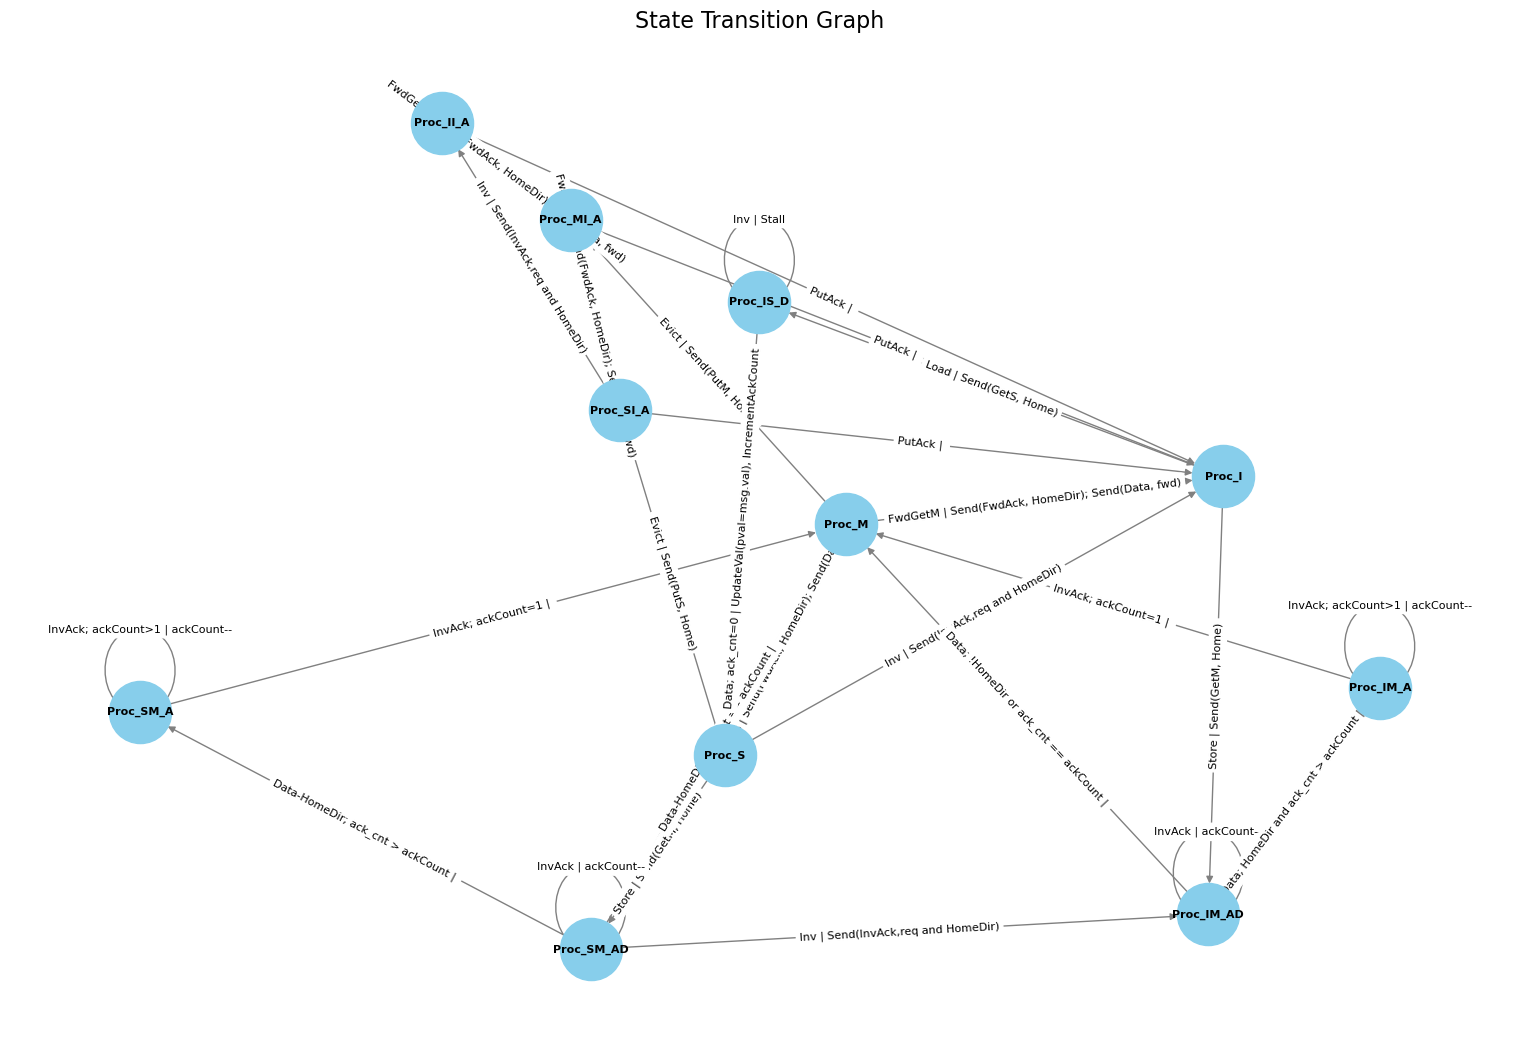

In [119]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add transitions to graph
for src, label, action, dest in transitions:
    G.add_edge(src, dest, label=label, action=action)

# Define layout
pos = nx.spring_layout(G, k=1.5, iterations=10000)  # Adjust 'k' for spacing

# Draw nodes and edges
plt.figure(figsize=(15, 10))
# nx.draw_networkx_nodes(G, pos, node_size=1500, node_color='lightblue')
nx.draw(G, pos, with_labels=True, font_size=8, font_weight='bold', node_size=2000, node_color='skyblue', edge_color='gray')
# nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True)

# Draw labels
edge_labels = {
    (u, v): f"{data['label']} | {data['action']}"
    for u, v, data in G.edges(data=True)
}
# nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("State Transition Graph", fontsize=16)
plt.show()
